## Part 1

In [67]:
#Import Packages
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

In [68]:
#Import the Data
train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

In [69]:
#Separate ID column to use for predictions
train_ID = train['PassengerId']
test_ID = test['PassengerId']

#Drop ID column 
train.drop("PassengerId", axis = 1, inplace = True)
test.drop("PassengerId", axis = 1, inplace = True)

### EDA from Assignment 2

In [70]:
#Fill Age NAs with median of each class
train['Age'] = train['Age'].fillna(train.groupby('Pclass')['Age'].transform('median'))

#Drop the Cabin, Name, Ticket variable
train = train.drop(columns = ["Cabin","Name","Ticket"], axis=1)

#Fill embarked NAs with the mode
train["Embarked"].fillna(train['Embarked'].value_counts().idxmax(), inplace=True)

#Encode Categorical Variables
df_embarked = pd.get_dummies(train['Embarked'], 
                                     prefix='embarked')

df_sex = pd.get_dummies(train['Sex'], 
                                prefix='sex')

df_plcass = pd.get_dummies(train['Pclass'], 
                                   prefix='pclass')

#Add encoded variables back to data
train_encod = pd.concat([train, 
                        df_embarked, 
                        df_sex, 
                        df_plcass], axis=1)
train_encod.head()

# Drop the original categorical columns because they have been encoded
train = train_encod.drop(['Pclass', 'Sex', 'Embarked'], axis=1)
train.head()

,Survived,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [71]:
#Split Data into Training/Test Sets
np.random.seed(42)


Y = train["Survived"]
X = train.drop("Survived",axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, random_state=42)
print(X_train.shape)
print(X_val.shape)

(712, 12)
(179, 12)


### Random Forest Model

In [72]:
#Create model instance 
rfc=RandomForestClassifier(random_state=42)

#Parameter Grid for tuning
param_grid = { 
    'n_estimators': [100,200,300,400,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [2,4,8,12,16,20],
    'bootstrap' : [True, False]
}

In [73]:
#Initiate gridsearch and fit model
#gs_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
#gs_rfc.fit(X_train, Y_train)

In [74]:
#Best Params
#gs_rfc.best_params_

After using GridSearch for Hyperparameter tuning, the optimal values for the 6 chosen hyperparameters were: 

'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_split': 8,
 'n_estimators': 200

In [75]:
#Create new RF model using tuned hyperparameters
rfc_final = RandomForestClassifier(random_state=42,bootstrap=False,criterion='gini',max_depth=6,
                                   max_features='auto',min_samples_split=8,n_estimators=200)
rfc_final.fit(X_train, Y_train)

#Predictions
rfc_pred_train = rfc_final.predict(X_train)
rfc_pred_val = rfc_final.predict(X_val)

In [76]:
#Accuracy Score for RF Classifier using the average of 5-fold cross validation
rfc_score = cross_val_score(rfc_final, X_train, Y_train, cv=5).mean()
print("Accuracy Score of Random Forest: ",rfc_score)

Accuracy Score of Random Forest:  0.8272234807446075


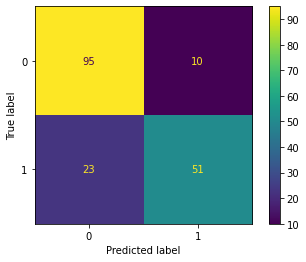

In [77]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val,rfc_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

In [78]:
#Precision/Recall 
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, precision_score, recall_score
print(classification_report(Y_val,rfc_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.84      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



Even with extensive hyperparameter tuning, our results are about the same as the ones from last week's assignment using Logistic Regression/LDA/KNN. The model has good metrics for predicting passengers that did not survive but struggles with predicting passengers that did survive. Hopefully we will see improved results using Gradient Boosted Trees. 

### Gradient Boosted Tree Classifier

In [79]:
from sklearn.ensemble import GradientBoostingClassifier

#Initiate GBC model
gbc = GradientBoostingClassifier(random_state=42)

#Parameter grid for gradient boosted trees
#Include hyperparameter for learning rate
gbc_param_grid = { 
    'n_estimators': [100,200,300,400,500],
    'learning_rate' : [0.05, 0.1, 0.25, 0.5, 0.75, 1],
    'max_depth' : [4,5,6,7,8],
    'min_samples_split': [4,6,8,10]
}

In [80]:
#gs_gbc = GridSearchCV(estimator=gbc, param_grid=gbc_param_grid, cv=5)
#gs_gbc.fit(X_train, Y_train)

In [81]:
#Best Params
#gs_gbc.best_params_

After using GridSearch for Hyperparameter tuning, the optimal values for the 4 hyperparameters were: 

{'learning_rate': 0.05,
 'max_depth': 4,
 'min_samples_split': 8,
 'n_estimators': 300}

In [82]:
#Create new GBC model using tuned hyperparameters
gbc_final = GradientBoostingClassifier(random_state=42,learning_rate = 0.05, max_depth = 4, 
                                       min_samples_split = 8,n_estimators = 300)
gbc_final.fit(X_train, Y_train)

#Predictions
gbc_pred_train = gbc_final.predict(X_train)
gbc_pred_val = gbc_final.predict(X_val)

In [83]:
#Accuracy Score for GBT Classifier using the average of 5-fold cross validation
gbc_score = cross_val_score(gbc_final, X_train, Y_train, cv=5).mean()
print("Accuracy Score of Gradient Boosted Trees: ",gbc_score)

Accuracy Score of Gradient Boosted Trees:  0.8230670737712991


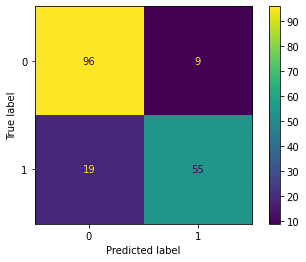

In [84]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val,gbc_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

In [85]:
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print(classification_report(Y_val,gbc_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       105
           1       0.86      0.74      0.80        74

    accuracy                           0.84       179
   macro avg       0.85      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



The gradient boosted tree classifier model performs slightly better than the RF model, but barely so. After browsing through a few Kaggle notebookes using similar modeling techniques, I see that most people are expeiencing similar problems and struggling to increase the F1 score for 'survived' above the 0.80-0.85 range. Perhaps more hyperparameter tuning or data preprocessing is required since the results have been largely unchanged in the combined 5 models used in assignment 2 and this assignment. 

### Model Comparison

In [86]:
#Function that computes model metrics 
def modMetrics(modName,predTrain,yTrain,predVal,yVal):

    metDict={'model':modName,   
              'F1 Score (Train)':f1_score(yTrain,predTrain),
              'F1 Score (Val)':f1_score(yVal,predVal),
              'Precision (Train)':precision_score(yTrain,predTrain),
              'Precision (Val)':precision_score(yVal,predVal),
              'Recall (Train)':recall_score(yTrain,predTrain),
              'Recall (Val)':recall_score(yVal,predVal)
            }
    return metDict   

In [87]:
RF_metrics = modMetrics("Random Forest",rfc_pred_train,Y_train,rfc_pred_val,Y_val)
GBC_metrics = modMetrics("Gradient Boosted Trees",gbc_pred_train,Y_train,gbc_pred_val,Y_val)

In [88]:
#Create comparison table
modList=[]
modList.append(RF_metrics)
modList.append(GBC_metrics)
pd.DataFrame(modList)

,model,F1 Score (Train),F1 Score (Val),Precision (Train),Precision (Val),Recall (Train),Recall (Val)
0,Random Forest,0.800000,0.755556,0.917874,0.836066,0.708955,0.689189
1,Gradient Boosted Trees,0.923679,0.797101,0.971193,0.859375,0.880597,0.743243


This comparison table clearl shows that the Gradient Boosted Trees model performs better than the Random Forest model on both the training and validation sets. There is a greater difference in values between training and test sets for the Gradient boosted model which could indicate some minor overfitting, but the performance drop-off is not enough to claim that the model will not generalize well. We will use the Gradient Boosted Trees model for the test set kaggle predictions. 

## Test Set Kaggle Predictions

In [89]:
#Transform Test Set
#Fill Age NAs with median of each class
test['Age'] = test['Age'].fillna(test.groupby('Pclass')['Age'].transform('median'))

#Drop the Cabin, Name, Ticket variable
test = test.drop(columns = ["Cabin","Name","Ticket"], axis=1)

#Fill embarked NAs with the mode
test["Embarked"].fillna(test['Embarked'].value_counts().idxmax(), inplace=True)

#Fill fare NAs with median
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

#Encode Categorical Variables
df_embarked = pd.get_dummies(test['Embarked'], 
                                     prefix='embarked')

df_sex = pd.get_dummies(test['Sex'], 
                                prefix='sex')

df_plcass = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

#Add encoded variables back to data
test_encod = pd.concat([test, 
                        df_embarked, 
                        df_sex, 
                        df_plcass], axis=1)
test_encod.head()

# Drop the original categorical columns because they have been encoded
test = test_encod.drop(['Pclass', 'Sex', 'Embarked'], axis=1)
test.head()

,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,34.5,0,0,7.8292,0,1,0,0,1,0,0,1
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1


In [90]:
#GBC Test PRedictions
gbc_predictions = gbc_final.predict(test)

gbc_df = pd.DataFrame()
gbc_df["PassengerId"] = test_ID
gbc_df["Survived"] = gbc_predictions

In [91]:
#Export to CSV
gbc_df.to_csv("GBC Predictions.csv",index=False)